# Multi-task framework


## Introduction
Even if in the context of data-driven CVs multi-task learning is often employed by optimizing different objective functions on the same dataset, in `mlcolvar` we implemented a framework to perform this on multiple dataset of different type at the same time.
This allow to cross-contaminate different methods, approaches and architectures to achieve better CV by exploiting in the best way all the data we have access to.

in this tutorial we will show how to setup a multi-task learned CV by taking as an example a semi-supervised learining scenario.

## Setup
The tool for building multi-task learned CVs in `mlcolvar` is the `MultiTaskCV` class

In [1]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.cvs import MultiTaskCV, AutoEncoderCV
from mlcolvar.core.loss import TDALoss
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics
from mlcolvar.utils.trainer import MetricsCallback

# Set seed for reproducibility
torch.manual_seed(42)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data: unlabeled + labeled data
We will use the two-state Muller-Brown potential as example using `p.x` and `p.y` as descriptors.
As datasets, will use:
- **unlabeled dataset** for the unsupervised component of the training obtained from high temperature simualtions
- **labeled dataset** for the supervised component based on unbiased simulations performed in the metastable basins. 

The multiple datasets can be directly passed as as list to `DictModule` that will automatically process them.

DictModule(dataset -> [DictDataset( "data": [5000, 2] ), DictDataset( "data": [4000, 2], "labels": [4000] )],
		     train_loader -> DictLoader(length=0.8, batch_size=1000, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=1000, shuffle=True))


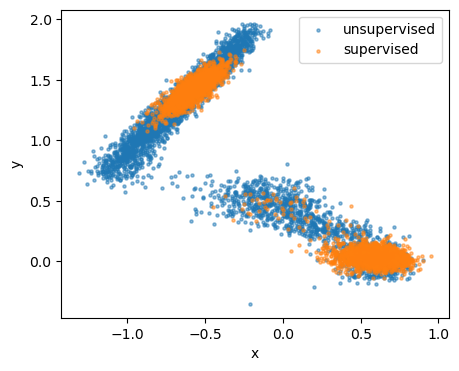

In [44]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files

n_states = 2

# load unlabeled data
filenames = ['data/muller-brown/biased/opes-y/COLVAR']
unsupervised_dataset, unsupervised_df = create_dataset_from_files(filenames, return_dataframe=True, filter_args={'regex':'p.x|p.y'}, verbose=False, start=0, stop=5000, create_labels=False)

# load labeled data
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]
supervised_dataset, supervised_df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, start=0, stop=2000, verbose=False)

# create multitask datamodule with both datasets
datamodule = DictModule(dataset=[unsupervised_dataset, supervised_dataset], batch_size=1000)
print(datamodule)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(unsupervised_df['p.x'], unsupervised_df['p.y'], s=5, alpha=0.5, label='unsupervised')
ax.scatter(supervised_df['p.x'], supervised_df['p.y'], s=5, alpha=0.5, label='supervised')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

### Define model
To define the multi-task CV we should:
- Define a main CV that will also determine the underlying architecture, here `AutoEncoderCV`.
- Define the auxiliary loss functions, here `TDALoss`
- Define a `MultiTaskCV` object that combines the two above  
- Manually set the Normalization statistics, if present, according to the two datasets. 

In [13]:
n_descriptors = 2
n_components = 1

nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

# define main CV
main_cv = AutoEncoderCV(encoder_layers=[n_descriptors, 32, 16, n_components], options=options)

# define auxiliary loss
aux_loss_fn = TDALoss(n_states, [-10, 10], [0.2, 0.2])

# combine the two model in a multi-task CV
model = MultiTaskCV(main_cv, auxiliary_loss_fns=[aux_loss_fn], loss_coefficients=[2])

# set statistics from the different datasets
stat = Statistics()
stat(unsupervised_dataset['data'])
stat(supervised_dataset['data']) 
model.norm_in.set_from_stats(stat)

### Define trainer and fit
From now on everything is the same as for 'normal' CVs

In [14]:
# define callbacks
metrics = MetricsCallback()
# define trainer
trainer = lightning.Trainer(callbacks=[metrics], max_epochs=500,
                    enable_checkpointing=False, enable_model_summary=False)
# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 499: 100%|██████████| 4/4 [00:00<00:00, 115.39it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 4/4 [00:00<00:00, 111.57it/s, v_num=17]


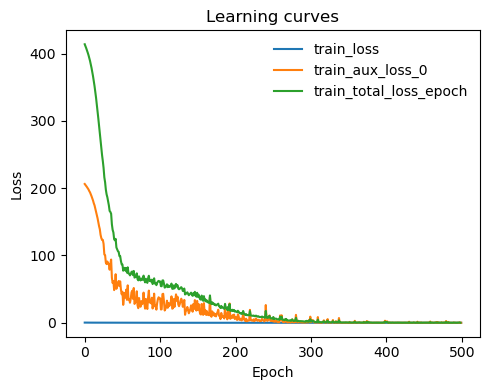

In [29]:
fig, ax = plt.subplots(figsize=(5,4))
metrics.metrics.keys()  
plot_metrics(metrics.metrics, ['train_loss', 'train_aux_loss_0', 'train_total_loss_epoch'], ax=ax)
plt.tight_layout()

### Analysis of the CV

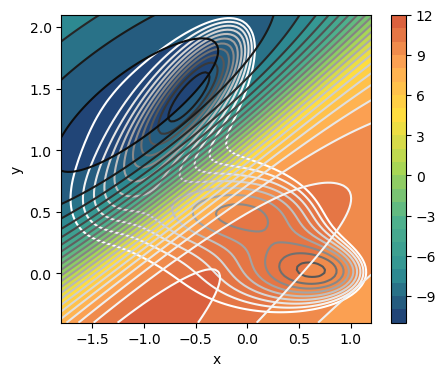

In [43]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)
ax.set_xlabel('x') 
ax.set_ylabel('y')
plt.show()

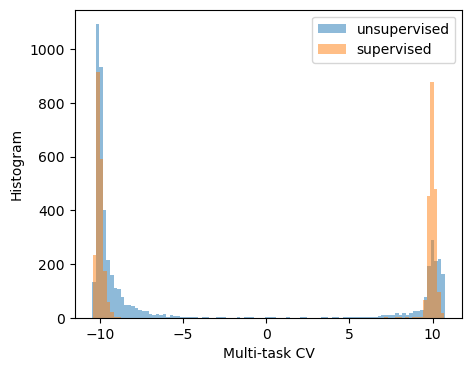

In [41]:
fig, ax = plt.subplots(figsize=(5,4))
with torch.no_grad():
    ax.hist(model(unsupervised_dataset['data']).numpy(),bins=100, alpha=0.5, label='unsupervised')
    ax.hist(model(supervised_dataset['data']).numpy(),bins=100, alpha=0.5, label='supervised')

ax.set_xlabel('Multi-task CV')
ax.set_ylabel('Histogram')
ax.legend()
plt.show()